### We are calculating the 

In [1]:
#pip install climate_indices

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.metrics import mean_squared_error
from climate_indices import indices
from climate_indices.compute import scale_values, Periodicity

In [2]:
#Importanat Definations

In [3]:
# resuable code

cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Function for frequent use for houlrly data
#https://open-meteo.com/en/docs/historical-weather-api#start_date=1950-01-01&end_date=2023-12-31&hourly=&daily=temperature_2m_mean&timezone=Europe%2FBerlin&models=era5_seamless
def daily_open_meteo_data(start_date:str, end_date:str, lat:list, long:list, variable):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
	"latitude": lat,
	"longitude": long,
	"start_date":start_date,
	"end_date": end_date,
	"timezone": "Europe/Berlin",
	"daily": variable,
	"models": ["era5_seamless"]
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]
	# Process daily data. The order of variables needs to be the same as requested.
	daily = response.Daily()
	daily_sum = daily.Variables(0).ValuesAsNumpy()

	daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
	)}
	daily_data["open_meteo"] = daily_sum

	daily_dataframe = pd.DataFrame(data = daily_data)
	if daily_dataframe.empty:
		return print("The daily limit reached")
	return daily_dataframe

def calculate_accuracy(original_data, predicted_data):
	mbe = np.mean(predicted_data - original_data)
	rmse = np.sqrt(mean_squared_error(original_data, predicted_data))
	correlation = np.corrcoef(original_data, predicted_data)[0, 1]

	# Print results
	print(f"Mean Bias Error (MBE): {mbe}")
	print(f"Root Mean Square Error (RMSE): {rmse}")
	print(f"Correlation: {correlation}")
	

# Function for frequent use for houlrly data
#https://open-meteo.com/en/docs/historical-weather-api#start_date=1950-01-01&end_date=2023-12-31&hourly=&daily=temperature_2m_mean&timezone=Europe%2FBerlin&models=era5_seamless
def Hourly_open_meteo_data(start_date:str, end_date:str, lat:list, long:list, variable):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
	"latitude": lat,
	"longitude": long,
	"start_date":start_date,
	"end_date": end_date,
	"timezone": "Europe/Berlin",
	"hourly": variable,
	"models": ["era5_seamless"]
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]
	# Process daily data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_snow_depth = hourly.Variables(0).ValuesAsNumpy()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	hourly_data["open_meteo"] = hourly_snow_depth

	hourly_dataframe = pd.DataFrame(data = hourly_data)

	if hourly_dataframe.empty:
		return print("The daily limit reached")
	return hourly_dataframe



# plots
def plot_my_bargraph(length:int,breath:int,xaxis,yaxis,title:str,xlabel:str,ylabel:str, widthv=0.5, colorv='blue',xtick = False):
    plt.figure(figsize=(length, breath))
    plt.bar(xaxis, yaxis, width = widthv , color=colorv)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    if xtick == True:
        plt.xticks(xaxis,rotation=45,fontsize=10)
    plt.tight_layout()
    plt.show()



def plot_my_bargraph_withnumbers(length:int,breath:int,xaxis,yaxis,title:str,xlabel:str,ylabel:str, widthv=0.5, colorv='blue'):
    plt.figure(figsize=(length, breath))
    plt.bar(xaxis, yaxis, width = widthv , color=colorv)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    for i, value in enumerate(yaxis):
        plt.text(xaxis[i], value + 1, str(value), ha='center', fontsize=9)
    plt.tight_layout()
    plt.xticks(xaxis,rotation=45,fontsize=10)
    plt.show()

## calcluating SEPI index

#### Vicente-Serrano, S. M., Beguería, S., & López-Moreno, J. I. (2010). "A Multiscalar Drought Index Sensitive to Global Warming: The Standardized Precipitation Evapotranspiration Index." Journal of Climate, 23(7), 1696–1718. https://doi.org/10.1175/2009JCLI2909.1

#### Projecting Hydroclimatic Extremes: Climate Change Impacts on Drought in a German Low Mountain Range Catchment



## Steps 
#### 1. Get the data from the API.
#### 2. Convert it to monthly (Monthly Mean)
#### 3. Calcluate D (D = p - et0)
#### 4. Normalize it using Climate Indicies library python.
#### plot the result. 


In [4]:
#open_meto_1950_2023_precipitation = daily_open_meteo_data("1950-01-01", "2023-12-31",[51.8], [10.62],"precipitation_sum")

In [5]:
#open_meto_1950_2023_et0 = daily_open_meteo_data("1950-01-01", "2023-12-31",[51.8], [10.62],"et0_fao_evapotranspiration")

### we are using the "Avereage_data_for_Harz.ipynb" to calculate the average.
### from Et0_average.xlsx and precipitation_average

In [6]:
open_meto_1950_2023_et0 = pd.read_excel(r'Et0_average.xlsx')
open_meto_1950_2023_precipitation = pd.read_excel(r'precipitation_avergae.xlsx')

In [7]:
#open_meto_1950_2023_et0.drop(['Unnamed: 0'],inplace=True)
open_meto_1950_2023_et0 

,date,average_et0
0,1949-12-31 23:00:00,0.455606
1,1950-01-01 23:00:00,0.794405
2,1950-01-02 23:00:00,0.205808
3,1950-01-03 23:00:00,0.245390
4,1950-01-04 23:00:00,0.170557
...,...,...
27023,2023-12-26 23:00:00,0.339704
27024,2023-12-27 23:00:00,1.193583
27025,2023-12-28 23:00:00,0.773106
27026,2023-12-29 23:00:00,0.549618


In [8]:
open_meto_1950_2023_precipitation

,date,average_precipitation
0,1949-12-31 23:00:00,0.000000
1,1950-01-01 23:00:00,10.900001
2,1950-01-02 23:00:00,2.240000
3,1950-01-03 23:00:00,1.680000
4,1950-01-04 23:00:00,5.220000
...,...,...
27023,2023-12-26 23:00:00,0.300000
27024,2023-12-27 23:00:00,0.040000
27025,2023-12-28 23:00:00,6.660000
27026,2023-12-29 23:00:00,2.320000


### Converting it into monthly data

In [9]:
# Precipitation data
open_meto_1950_2023_precipitation.set_index('date',inplace = True)
open_meto_1950_2023_precipitation.fillna(0,inplace=True) # to be sure it do not contain NAN values
open_meto_1950_2023_precipitation_monthly = open_meto_1950_2023_precipitation.resample("M").mean()
open_meto_1950_2023_precipitation_monthly.rename(columns={'average_precipitation': 'precipitation'}, inplace=True)

In [10]:
open_meto_1950_2023_precipitation_monthly.head()

,precipitation
date,
1949-12-31,0.000000
1950-01-31,1.674839
1950-02-28,3.137857
1950-03-31,0.954839
1950-04-30,2.612000


In [11]:
# Eto data
open_meto_1950_2023_et0.set_index('date',inplace = True)
open_meto_1950_2023_et0.fillna(0,inplace=True) # to be sure it do not contain NAN values
open_meto_1950_2023_eto_monthly = open_meto_1950_2023_et0.resample("M").mean()
open_meto_1950_2023_eto_monthly.rename(columns={'average_et0': 'ET0'}, inplace=True)

In [12]:
open_meto_1950_2023_eto_monthly.head()

,ET0
date,
1949-12-31,0.455606
1950-01-31,0.451574
1950-02-28,0.715936
1950-03-31,1.245547
1950-04-30,1.801720


### Calculating water balance (WB)

In [13]:
WB_1950_2023_SPEI_monthly = open_meto_1950_2023_eto_monthly

In [24]:
WB_1950_2023_SPEI_monthly['Deficit'] = open_meto_1950_2023_precipitation_monthly['precipitation'] - open_meto_1950_2023_eto_monthly['ET0']

### Using the climate-indices library to calcluate the SPEI.
### Climate-indices: https://pypi.org/project/climate_indices/




# Citation
author = "James Adams",
title  = "climate_indices, an open source Python library providing reference implementations of commonly used climate indices",
url    = "https://github.com/monocongo/climate_indices",
month  = "may",
year   = "2017--"

In [25]:
## defination for Calculating the SPEI
def compute_SPEI(distribution,scale,pet,precips):
    spei_values = indices.spei(
    pet_mm= pet.values,
    precips_mm= precips.values,
    scale=scale,
    distribution=distribution,
    data_start_year=1950,
    calibration_year_initial=1950,
    calibration_year_final=2023,
    periodicity= Periodicity.monthly,
)
    return spei_values


#data[name_field] = spei_values

In [26]:
 # Use Gamma distribution, and 3 month scale
distribution = indices.Distribution.gamma 

WB_1950_2023_SPEI_monthly['SPEI2'] = compute_SPEI(distribution,2,open_meto_1950_2023_eto_monthly['ET0'],open_meto_1950_2023_precipitation_monthly['precipitation'])
WB_1950_2023_SPEI_monthly['SPEI3'] = compute_SPEI(distribution,3,open_meto_1950_2023_eto_monthly['ET0'],open_meto_1950_2023_precipitation_monthly['precipitation'])
WB_1950_2023_SPEI_monthly['SPEI6'] = compute_SPEI(distribution,6,open_meto_1950_2023_eto_monthly['ET0'],open_meto_1950_2023_precipitation_monthly['precipitation'])
WB_1950_2023_SPEI_monthly['SPEI12'] = compute_SPEI(distribution,12,open_meto_1950_2023_eto_monthly['ET0'],open_meto_1950_2023_precipitation_monthly['precipitation'])

In [27]:
WB_1950_2023_SPEI_monthly

,ET0,Deficit,SPEI2,SPEI3,SPEI6,SPEI12
date,,,,,,
1949-12-31,0.455606,-0.455606,NaN,NaN,NaN,NaN
1950-01-31,0.451574,1.223265,-2.029300,NaN,NaN,NaN
1950-02-28,0.715936,2.421921,0.915711,-0.879037,NaN,NaN
1950-03-31,1.245547,-0.290708,0.287169,0.055158,NaN,NaN
1950-04-30,1.801720,0.810280,0.085899,0.781096,NaN,NaN
...,...,...,...,...,...,...
2023-08-31,2.937446,0.179973,0.069178,-0.537040,-0.490230,-0.302145
2023-09-30,2.715662,-1.391662,-0.396478,-0.532123,-1.302011,-0.920391
2023-10-31,1.231677,2.176710,0.066877,0.446366,-0.835522,-0.459062


In [28]:
SPEI__monthly = WB_1950_2023_SPEI_monthly.copy()
SPEI__monthly.drop(['ET0', 'Deficit'],axis=1,inplace=True)
SPEI__monthly

,SPEI2,SPEI3,SPEI6,SPEI12
date,,,,
1949-12-31,NaN,NaN,NaN,NaN
1950-01-31,-2.029300,NaN,NaN,NaN
1950-02-28,0.915711,-0.879037,NaN,NaN
1950-03-31,0.287169,0.055158,NaN,NaN
1950-04-30,0.085899,0.781096,NaN,NaN
...,...,...,...,...
2023-08-31,0.069178,-0.537040,-0.490230,-0.302145
2023-09-30,-0.396478,-0.532123,-1.302011,-0.920391
2023-10-31,0.066877,0.446366,-0.835522,-0.459062


In [29]:
SPEI__monthly.fillna(0, inplace=True)

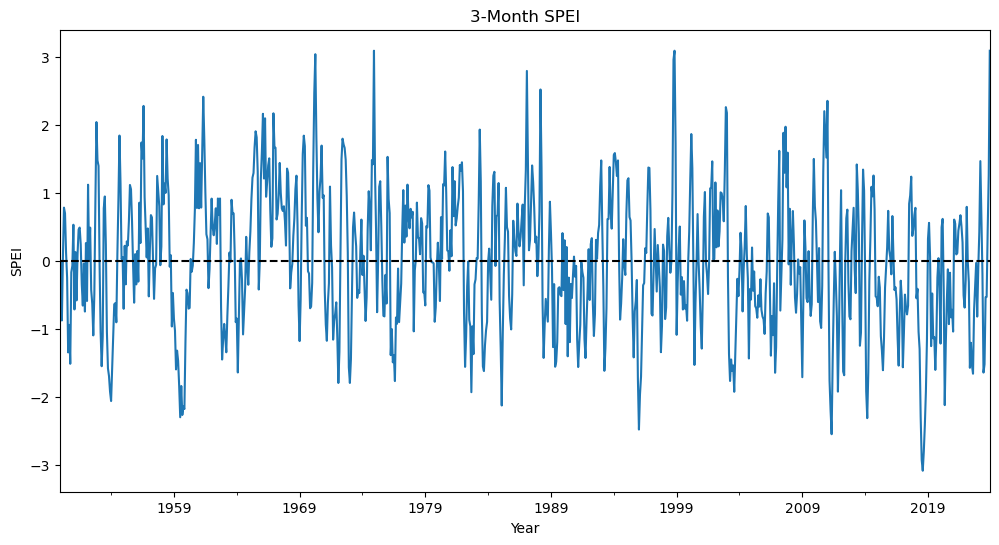

In [30]:
SPEI__monthly['SPEI3'].plot(figsize=(12, 6), title="3-Month SPEI")
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Year') 
plt.ylabel('SPEI')
plt.show()

## Now definig the seasons for better understanding.

In [14]:
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
SPEIs = ['SPEI2', 'SPEI3', 'SPEI6', 'SPEI12']
def seasons_create(date):
    month = date.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [9, 10, 11]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Winter'
    


In [32]:
SPEI_all_monthly = WB_1950_2023_SPEI_monthly.copy()

In [33]:
SPEI_all_monthly.drop(['ET0', 'Deficit'],axis=1,inplace=True)

In [34]:
#pei_data = SPEI_monthly.copy() 
SPEI_all_monthly['Season'] = SPEI_all_monthly.index.map(seasons_create)

### dividing the time period in 3 part.

In [35]:
SPEI_all_monthly['Year'] = SPEI_all_monthly.index.year
# separate the different year
time_periods = {
    '1950-1980': (1950, 1980),
    '1981-2010': (1981, 2010),
    '2011-2023': (2011, 2023)
}

In [36]:
severe_drought_days = []

In [37]:
severe_drought_days = []

# Loop for time period
for period, (start_year, end_year) in time_periods.items():
    
    period_data = SPEI_all_monthly[(SPEI_all_monthly['Year'] >= start_year) & (SPEI_all_monthly['Year'] <= end_year)]
    
    # Loop for each season
    for season in seasons:
        
        d_season = period_data[period_data['Season'] == season]
        
        # Loop through each SPEI scale
        for spei_scale in SPEIs:
            
            drought_day_count = (d_season[spei_scale] < -1.5).sum()
            
            
            severe_drought_days.append({
                'Period': period,
                'Season': season,
                'SPEI_Scale': spei_scale,
                'Severe_Droughts_days': drought_day_count
            })

In [38]:
pd_severe_drought_days = pd.DataFrame(severe_drought_days)
print(pd_severe_drought_days)

       Period  Season SPEI_Scale  Severe_Droughts_days
0   1950-1980  Spring      SPEI2                     2
1   1950-1980  Spring      SPEI3                     2
2   1950-1980  Spring      SPEI6                     7
3   1950-1980  Spring     SPEI12                     3
4   1950-1980  Summer      SPEI2                     3
5   1950-1980  Summer      SPEI3                     4
6   1950-1980  Summer      SPEI6                     5
7   1950-1980  Summer     SPEI12                     6
8   1950-1980  Autumn      SPEI2                     5
9   1950-1980  Autumn      SPEI3                     6
10  1950-1980  Autumn      SPEI6                     3
11  1950-1980  Autumn     SPEI12                     3
12  1950-1980  Winter      SPEI2                     8
13  1950-1980  Winter      SPEI3                     7
14  1950-1980  Winter      SPEI6                     8
15  1950-1980  Winter     SPEI12                     5
16  1981-2010  Spring      SPEI2                     5
17  1981-2

### Preparing the data to plot

### Seperate the data by season for clear understanding.

In [39]:
time_periods = ['1950-1980', '1981-2010', '2011-2023']
# font size
f_title = 14
f_other = 12

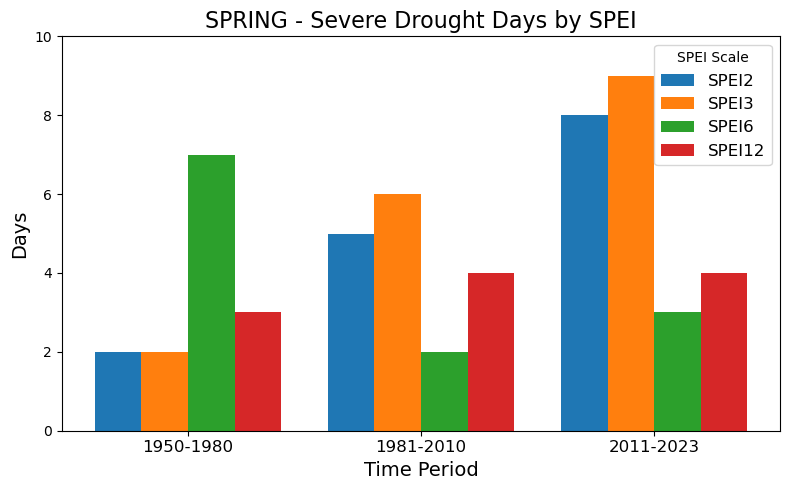

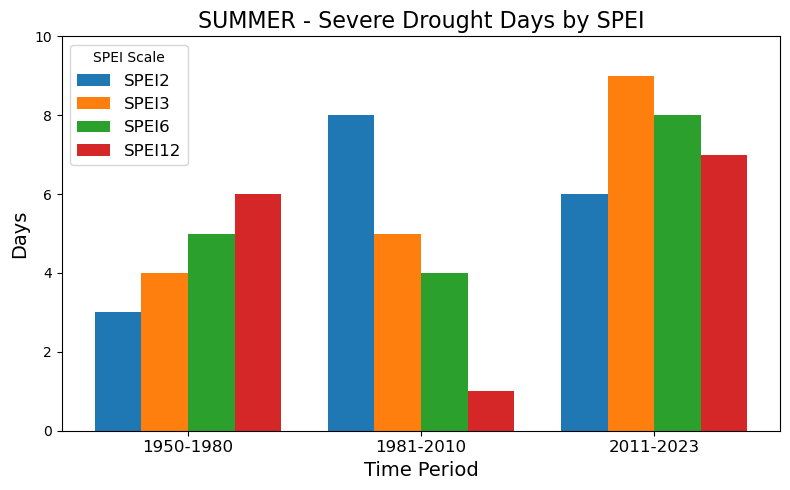

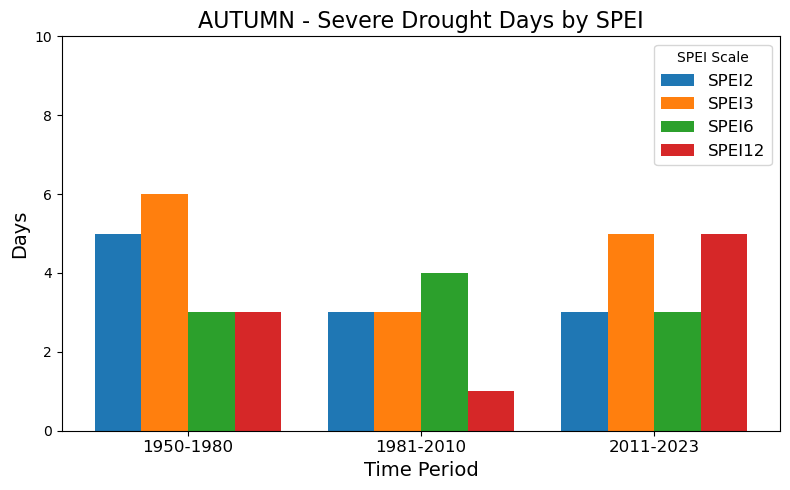

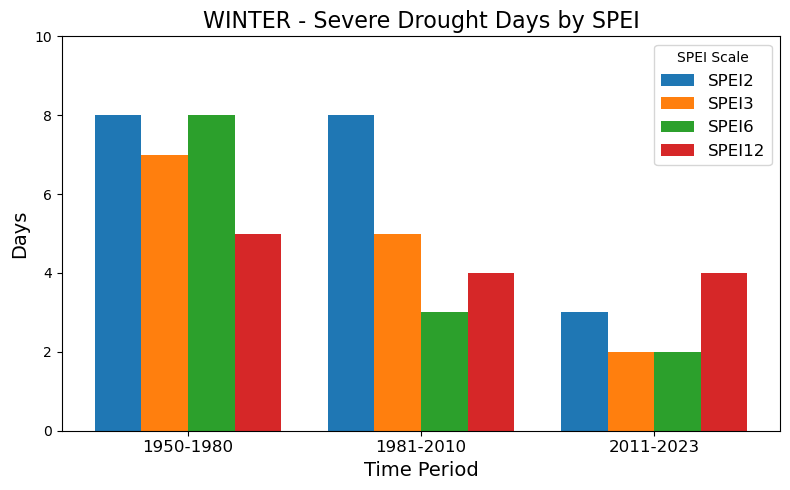

In [41]:
for Season in seasons:
    plt.figure(figsize=(9, 5))
    filtered_data = pd_severe_drought_days[pd_severe_drought_days['Season'] == Season]
    
    bar_width = 0.2 
    x_ticks = np.arange(3) #length of time period.
    
    for i, scale in enumerate(SPEIs):
        D_days_count = []
        
        for period in time_periods:
            value = filtered_data[
                (filtered_data['Period'] == period) & (filtered_data['SPEI_Scale'] == scale)]
            ['Severe_Droughts_days'].sum()


            D_days_count.append(0 if np.isnan(value) else value) # because all have Null value 
    
        plt.bar(x_ticks + (bar_width * i),  D_days_count, bar_width, label=scale)
    
    
    plt.title(f'{Season} - Severe Drought days by SPEI', fontsize=f_title)
    plt.xlabel('Time Period', fontsize=f_title)
    plt.ylabel('Days', fontsize=f_title)
    #plt.xticks(time_periods)


    plt.xticks(x_ticks + bar_width * (4 - 1) / 2, time_periods, fontsize=f_other) # 4 for different SPEI scale
    plt.ylim(0, max(filtered_data['Severe_Droughts_days'].fillna(0)) + 5)  # to properly fit the values
    plt.legend(title='SPEI Scale', fontsize=f_other)
    
    plt.tight_layout()
    plt.show()

## Analysis on precipitation 

### In order to check the anomalies we take year 1950-1980 as refrence.
### Firstly calclulating the refrence year data and then comparing it with other data.


### Diving the data into seasons 

In [25]:
#open_meto_1950_2023_precipitation
precipitation_all = open_meto_1950_2023_precipitation_monthly.copy()
#Reference_period = open_meto_1950_2023_precipitation.loc["1950-01-01":"1980-12-31"]
precipitation_all['Season'] = precipitation_all.index.map(seasons_create)

In [26]:
#reference Year
precipitation_all['Year'] = precipitation_all.index.year
precipitation_refrence = precipitation_all[(precipitation_all["Year"] >= 1950) & (precipitation_all["Year"] <= 1980)]
precipitation_refrence

,precipitation,Season,Year
date,,,
1950-01-31,1.674839,Winter,1950
1950-02-28,3.137857,Winter,1950
1950-03-31,0.954839,Spring,1950
1950-04-30,2.612000,Spring,1950
1950-05-31,3.352258,Spring,1950
...,...,...,...
1980-08-31,2.256774,Summer,1980
1980-09-30,2.214667,Autumn,1980
1980-10-31,1.336129,Autumn,1980


In [27]:
# Mean for refrence year
precipitation_refrence_mean = precipitation_refrence.groupby('Season')["precipitation"].mean()
precipitation_refrence_mean

Season
Autumn    1.817806
Spring    2.145733
Summer    2.639040
Winter    1.877424
Name: precipitation, dtype: float64

In [ ]:
#Anomolies

def get_anomolies_percentatge(data):
    season = data["season"].iloc[0]
    precipitation_refrence_mean = precipitation_refrence_mean[season]
    data["anomaly"] = ((data["precipitation"] - precipitation_refrence_mean) /precipitation_refrence_mean) * 100
    return data


In [ ]:
anomalies = data.groupby(["year", "season"]).apply(calculate_anomalies)

# Keep only the relevant columns
anomalies = anomalies[["year", "season", "precipitation", "anomaly"]]